In [4]:
# SQL Engine
import sqlalchemy as sa

db_path = r"C:\Users\rober\Documents\Python\bitcoin_gold_analysis\data\bitcoin_gold_database.db"
engine = sa.create_engine(f'sqlite:///{db_path}')

inspector = sa.inspect(engine)
print(f"Tables found: {inspector.get_table_names()}")

Tables found: ['macro_data', 'market_data_filled', 'market_data_sycned']


In [5]:
columns = inspector.get_columns('macro_data')
columns

[{'name': 'Date',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'primary_key': 0},
 {'name': 'CPI',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'primary_key': 0},
 {'name': 'M2',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'primary_key': 0},
 {'name': 'CPI_YoY',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'primary_key': 0},
 {'name': 'M2_YoY',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'primary_key': 0}]

In [6]:
import pandas as pd

# Pull Daily Asset Data
df_assets = pd.read_sql("SELECT Date, BTC, Gold FROM market_data_filled", engine)
df_assets['Date'] = pd.to_datetime(df_assets['Date'])
df_assets.sort_values('Date', inplace=True)

# Pull Monthly CPI Data
df_cpi = pd.read_sql("SELECT Date, CPI FROM macro_data", engine)
df_cpi['Date'] = pd.to_datetime(df_cpi['Date'])
df_cpi.sort_values('Date', inplace=True)

In [7]:
# Align daily prices with the latest available monthly CPI
df = pd.merge_asof(df_assets, df_cpi, on='Date', direction='backward')

# Fill any early gaps and set the Date as the index
df['CPI'] = df['CPI'].ffill()
df.set_index('Date', inplace=True)

In [8]:
# Calculate Real Price
# Real Price = Nominal Price x (CPI-Base / CPI-Current)

# CPI Base
base_cpi = df['CPI'].iloc[0]

# Calculate Real Prices for Bitcoin + Gold 
df['BTC_Real'] = df['BTC'] * (base_cpi / df['CPI'])
df['Gold_Real'] = df['Gold'] * (base_cpi / df['CPI'])

# Index to Base 100 to Calculate Purchasing Power
df['BTC_Power'] = (df['BTC_Real'] / df['BTC_Real'].iloc[0]) * 100
df['Gold_Power'] = (df['Gold_Real'] / df['Gold_Real'].iloc[0]) * 100

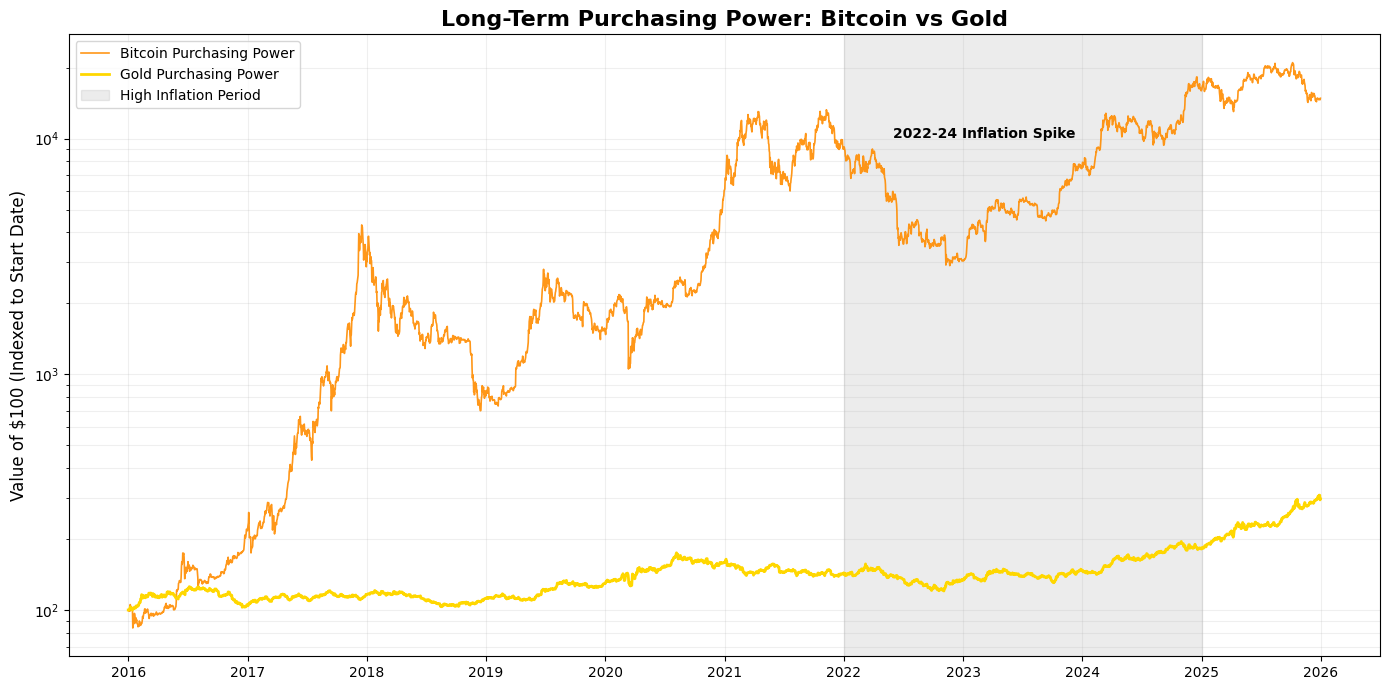

In [9]:
# Visualisation
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

# Plot Lines
plt.plot(df.index, df['BTC_Power'], label='Bitcoin Purchasing Power', color='darkorange', lw=1.2, alpha=0.9)
plt.plot(df.index, df['Gold_Power'], label='Gold Purchasing Power', color='gold', lw=2)

# Define Highlight Dates as Timestamps
highlight_start = pd.to_datetime('2022-01-01')
highlight_end = pd.to_datetime('2024-12-31')
text_position = pd.to_datetime('2022-06-01') 

# Add Highlighted Shading
plt.axvspan(highlight_start, highlight_end, color='gray', alpha=0.15, label='High Inflation Period')

# Add Text Label Using Timestamp
plt.text(text_position, df['BTC_Power'].max() * 0.5, '2022-24 Inflation Spike', 
         fontsize=10, fontweight='bold', rotation=360, verticalalignment='center')

# Formatting
plt.yscale('log')
plt.title('Long-Term Purchasing Power: Bitcoin vs Gold', fontsize=16, fontweight='bold')
plt.ylabel('Value of $100 (Indexed to Start Date)', fontsize=12)

plt.grid(True, which="both", ls="-", alpha=0.2)
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [16]:
# Pull M2 Data
query_m2 = "SELECT Date, M2 FROM macro_data"
df_m2 = pd.read_sql(query_m2, engine)
df_m2['Date'] = pd.to_datetime(df_m2['Date'])

# Merge M2 Into Existing DataFrame (df)
df = pd.merge_asof(df.sort_index(), df_m2.sort_values('Date'), on='Date', direction='backward')

# Handle the Index and Gaps
df.set_index('Date', inplace=True)
df['M2'] = df['M2'].ffill()

In [17]:
# Calculate M2 Ratio
df['BTC_M2_Ratio'] = df['BTC'] / df['M2']
df['Gold_M2_Ratio'] = df['Gold'] / df['M2']

# Index to 100 for Comparison
df['BTC_M2_Index'] = (df['BTC_M2_Ratio'] / df['BTC_M2_Ratio'].iloc[0]) * 100
df['Gold_M2_Index'] = (df['Gold_M2_Ratio'] / df['Gold_M2_Ratio'].iloc[0]) * 100

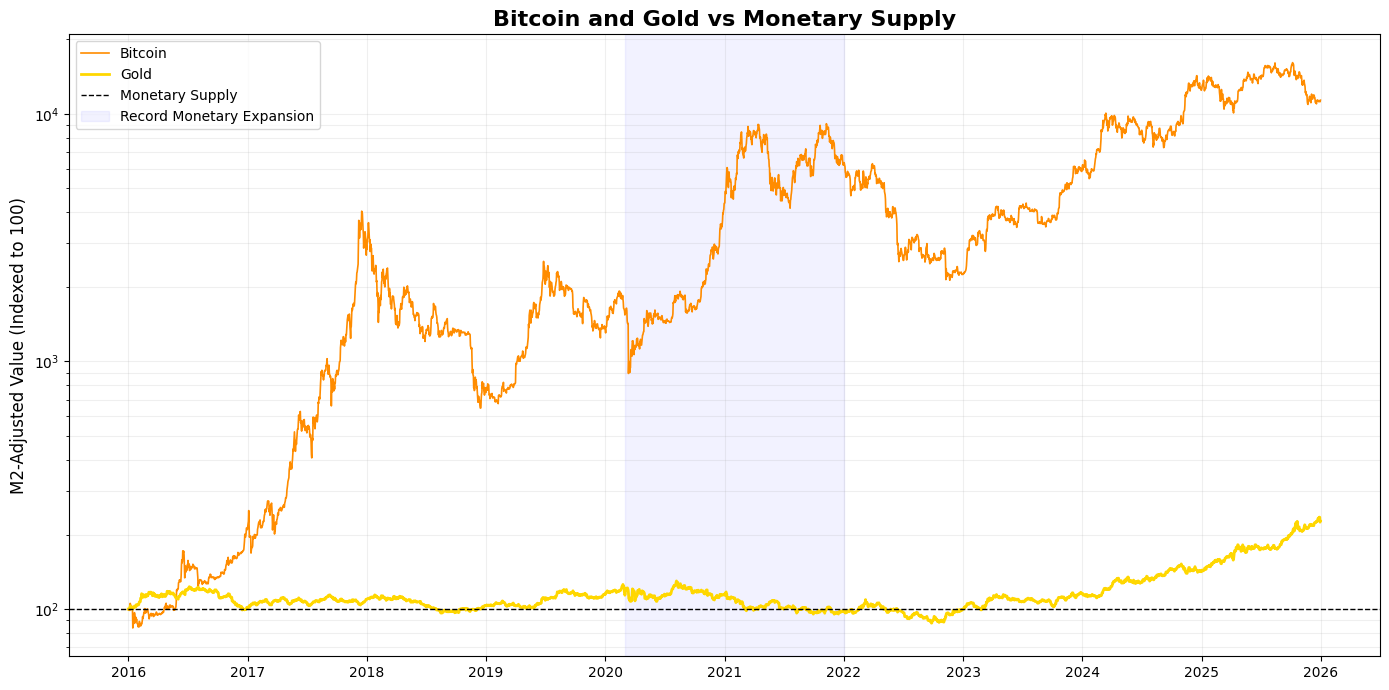

In [23]:
# Visualisation

plt.figure(figsize=(14, 7))

# Plot Performance
plt.plot(df.index, df['BTC_M2_Index'], label='Bitcoin', color='darkorange', lw=1.2)
plt.plot(df.index, df['Gold_M2_Index'], label='Gold', color='gold', lw=2)

# Set Debasement Threshold
plt.axhline(100, color='black', lw=1, linestyle='--', label='Monetary Supply')

# Highlight M2 2020-2021 Expansion 
m2_spike_start = pd.to_datetime('2020-03-01')
m2_spike_end = pd.to_datetime('2021-12-31')
plt.axvspan(m2_spike_start, m2_spike_end, color='blue', alpha=0.05, label='Record Monetary Expansion')

# Formatting
plt.yscale('log')
plt.title('Bitcoin and Gold vs Monetary Supply', fontsize=16, fontweight='bold')
plt.ylabel('M2-Adjusted Value (Indexed to 100)', fontsize=12)
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()